In [1]:
import pandas as pd
from calculations import *
from plotting import *

In [2]:
city_attributes = pd.read_csv('data/city_attributes.csv')
city_attributes.head()

,loc,lat,lng,city,state,white population,black population,asian/pacific islander population,hispanic population
0,"Albany,NY",42.652579,-73.756232,Albany,NY,49842,26819,7351,9612
1,"Anaheim,CA",33.836593,-117.914301,Anaheim,CA,87991,7843,57829,187931
2,"Arlington,TX",32.735687,-97.108066,Arlington,TX,155606,83045,26868,112283
3,"Aurora,CO",39.729432,-104.831919,Aurora,CO,162887,54510,22287,102317
4,"Austin,TX",30.267153,-97.743061,Austin,TX,445269,66724,63752,316709


In [3]:
def read_city_stops_csv_online(city, state, file_date = '2019_02_25'):
    #Only one with different date right now is Long Beach. Need to make this more robust if file date changes.
    url = "http://stacks.stanford.edu/file/druid:tr137st9964/tr137st9964_"
    if city != 'Long Beach':
        file_date = '2019_02_25'
    else:
        file_date = '2019_02_26'
    url += state.lower() + '_' + city.replace(" ", "_").lower() + "_" + file_date + ".csv.zip"
    print(url)
    try:
        df = pd.read_csv(url)
        return df
    except:
        print(url + " not found.")
        return None

In [4]:
# austin = read_city_stops_csv_online('Austin', 'TX')
# burlington = read_city_stops_csv_online('Burlington', 'VT')
# new_orleans = read_city_stops_csv_online('New Orleans', 'LA')
# ar = read_city_stops_csv_online('Arlington', 'TX')


In [5]:
# new_orleans_2017 = new_orleans[pd.to_datetime(new_orleans['date']).apply(lambda date:date.year) == 2017]

# new_orleans_2017 = new_orleans
# new_orleans_2017['contraband_found'] = new_orleans_2017['contraband_found'].astype(float)
# new_orleans_2017.groupby(['subject_race', 'district'])['contraband_found'].mean()

In [6]:
# new_orleans['search_conducted'] = new_orleans['search_conducted'].astype(float)
# test2 = calc_search_rates(new_orleans, ['subject_race', 'district'])

In [7]:
# (new_orleans_2017[(new_orleans_2017['subject_race'] == 'black') &\
#                  (new_orleans_2017['district'] == 2)]['contraband_found']).sum() / (new_orleans_2017[(new_orleans_2017['subject_race'] == 'black') &\
#                  (new_orleans_2017['district'] == 2)]['contraband_found'].notnull().sum())

In [8]:
import time

def conduct_analysis(city_attributes_subset):
    
    rates = {
        'search_rate': pd.DataFrame(columns = ['city', 'state', 'district', 'minority_group', 'white_search_rate',
                                              'minority_search_rate', 'n']),
        'arrest_rate': pd.DataFrame(columns = ['city', 'state', 'district', 'minority_group', 'white_arrest_rate',
                                              'minority_arrest_rate', 'n']),
        'frisk_rate': pd.DataFrame(columns = ['city', 'state', 'district', 'minority_group', 'white_frisk_rate',
                                              'minority_frisk_rate', 'n']),
        'hit_rate': pd.DataFrame(columns = ['city', 'state', 'district', 'minority_group', 'white_hit_rate',
                                              'minority_hit_rate', 'n']),
        'stop_rate': pd.DataFrame(columns = ['city', 'state', 'minority_group', 'white_stop_rate', 'minority_stop_rate',
                                            'n'])
    }
    
    for i in city_attributes_subset.index:
#     for i in range(5):
        time.sleep(5)
        city_row = city_attributes.loc[i]
        city = city_row['city']
        state = city_row['state']
        stops_df = read_city_stops_csv_online(city, state)
        if stops_df is not None and 'subject_race' in list(stops_df.columns):
            stops_df = stops_df[stops_df['type'] == 'vehicular']
            stops_df['date'] = pd.to_datetime(stops_df['date'])
            
            #For simplicity, only look 2017
            stops_df = stops_df[stops_df['date'].apply(lambda date: date.year) == \
                                     2017]
            if len(stops_df) > 0:
                population_df = pd.DataFrame(city_row[['white population', 'black population', 
                                          'asian/pacific islander population', 'hispanic population']]).reset_index()
                population_df.columns = ['subject_race', 'num_people']
                races = ['white', 'black', 'asian/pacific islander', 'hispanic']
                population_df['subject_race'] = races
                # stop rates
                stop_rates = calc_stop_rates(stops_df, population_df, ['subject_race'])
                group_sizes = calc_group_size(stops_df, 'subject_race', False)
                group_sizes.columns = ['minority_group', 'n']
                minority_grp = list(set(stop_rates.subject_race)-set(['white']))
                compare_stop_rates = compare_rates('stop_rate', stop_rates, 'white', 
                                                minority_grp, 'subject_race')
                compare_stop_rates['city'] = city
                compare_stop_rates['state'] = state
                compare_stop_rates = compare_stop_rates.merge(group_sizes)
                rates['stop_rate'] = rates['stop_rate'].append(compare_stop_rates, sort = True)


                #San Diego dataset has service_area instead of district.
                if 'service_area' in list(stops_df.columns):
                    stops_df['district'] = stops_df['service_area']

                if 'district' in list(stops_df.columns):
                    group_sizes = calc_group_size(stops_df, ['subject_race', 'district'], False)
                    # Make merge easier. Since white isn't a minority race, it's automatically gotten rid of 
                    group_sizes.columns = ['minority_group', 'district', 'n']
                    group_sizes['n'] = group_sizes['n'].astype(int)

                    # search rates
                    if "search_conducted" in list(stops_df.columns):
                        stops_df['search_conducted'] = stops_df['search_conducted'].astype(float)
                        search_rates = calc_search_rates(stops_df, ['subject_race', 'district'])
                        minority_grp = list(set(search_rates.subject_race)-set(['white']))
                        compare_search_rates = compare_rates('search_rate', search_rates, 'white', 
                                                    minority_grp, 'subject_race')
                        compare_search_rates['city'] = city
                        compare_search_rates['state'] = state
                        compare_search_rates = compare_search_rates.merge(group_sizes)
                        rates['search_rate'] = rates['search_rate'].append(compare_search_rates, sort = True)

                    # arrest rates
                    if "arrest_made" in list(stops_df.columns):
                        stops_df['arrest_made'] = stops_df['arrest_made'].astype(float)
                        arrest_rates = calc_arrest_rates(stops_df, ['subject_race', 'district'])
                        minority_grp = list(set(arrest_rates.subject_race)-set(['white']))
                        # for San Antonio, TX, most arrest rates are NaN, dropping all means 
                        # there is no white arrest rates to compare to
                        if 'white' in arrest_rates.subject_race.unique():
                            
                            compare_arrest_rates = compare_rates('arrest_rate', arrest_rates, 'white', 
                                                                 minority_grp, 'subject_race')
                            compare_arrest_rates['city'] = city
                            compare_arrest_rates['state'] = state
                            compare_arrest_rates = compare_arrest_rates.merge(group_sizes)
                            rates['arrest_rate'] = rates['arrest_rate'].append(compare_arrest_rates, sort = True)

                    # frisk rates
                    if "frisk_performed" in list(stops_df.columns):
                        stops_df['frisk_performed'] = stops_df['frisk_performed'].astype(float)
                        frisk_rates = calc_frisk_rates(stops_df, ['subject_race', 'district'])
                        minority_grp = list(set(frisk_rates.subject_race)-set(['white']))
                        compare_frisk_rates = compare_rates('frisk_rate', frisk_rates, 'white', 
                                minority_grp, 'subject_race')
                        compare_frisk_rates['city'] = city
                        compare_frisk_rates['state'] = state
                        compare_frisk_rates = compare_frisk_rates.merge(group_sizes)
                        rates['frisk_rate'] = rates['frisk_rate'].append(compare_frisk_rates, sort = True)

                    # hit rates
                    if "contraband_found" in list(stops_df.columns):
                        stops_df['contraband_found'] = stops_df['contraband_found'].astype(float)
                        hit_rates = calc_hit_rates(stops_df, ['subject_race', 'district'])
                        minority_grp = list(set(hit_rates.subject_race)-set(['white']))
                        compare_hit_rates = compare_rates('hit_rate', hit_rates, 'white', 
                                minority_grp, 'subject_race')
                        compare_hit_rates['city'] = city
                        compare_hit_rates['state'] = state
                        compare_hit_rates = compare_hit_rates.merge(group_sizes)
                        rates['hit_rate'] = rates['hit_rate'].append(compare_hit_rates, sort = True)
            
    return rates

In [9]:
rates = conduct_analysis(city_attributes)
# test = conduct_analysis(city_attributes)

http://stacks.stanford.edu/file/druid:tr137st9964/tr137st9964_ny_albany_2019_02_25.csv.zip
http://stacks.stanford.edu/file/druid:tr137st9964/tr137st9964_ca_anaheim_2019_02_25.csv.zip
http://stacks.stanford.edu/file/druid:tr137st9964/tr137st9964_tx_arlington_2019_02_25.csv.zip
http://stacks.stanford.edu/file/druid:tr137st9964/tr137st9964_co_aurora_2019_02_25.csv.zip
http://stacks.stanford.edu/file/druid:tr137st9964/tr137st9964_tx_austin_2019_02_25.csv.zip
http://stacks.stanford.edu/file/druid:tr137st9964/tr137st9964_ca_bakersfield_2019_02_25.csv.zip
http://stacks.stanford.edu/file/druid:tr137st9964/tr137st9964_md_baltimore_2019_02_25.csv.zip
http://stacks.stanford.edu/file/druid:tr137st9964/tr137st9964_vt_burlington_2019_02_25.csv.zip
http://stacks.stanford.edu/file/druid:tr137st9964/tr137st9964_nj_camden_2019_02_25.csv.zip


C:\Users\shengsiong\Anaconda3\envs\ac221\lib\site-packages\IPython\core\interactiveshell.py:3296: DtypeWarning: Columns (9,12,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


http://stacks.stanford.edu/file/druid:tr137st9964/tr137st9964_nc_charlotte_2019_02_25.csv.zip
http://stacks.stanford.edu/file/druid:tr137st9964/tr137st9964_il_chicago_2019_02_25.csv.zip
http://stacks.stanford.edu/file/druid:tr137st9964/tr137st9964_il_chicago_2019_02_25.csv.zip not found.
http://stacks.stanford.edu/file/druid:tr137st9964/tr137st9964_oh_cincinnati_2019_02_25.csv.zip
http://stacks.stanford.edu/file/druid:tr137st9964/tr137st9964_oh_columbus_2019_02_25.csv.zip
http://stacks.stanford.edu/file/druid:tr137st9964/tr137st9964_co_denver_2019_02_25.csv.zip
http://stacks.stanford.edu/file/druid:tr137st9964/tr137st9964_nc_durham_2019_02_25.csv.zip
http://stacks.stanford.edu/file/druid:tr137st9964/tr137st9964_nc_fayetteville_2019_02_25.csv.zip
http://stacks.stanford.edu/file/druid:tr137st9964/tr137st9964_in_fort_wayne_2019_02_25.csv.zip
http://stacks.stanford.edu/file/druid:tr137st9964/tr137st9964_az_gilbert_2019_02_25.csv.zip
http://stacks.stanford.edu/file/druid:tr137st9964/tr137st

C:\Users\shengsiong\Anaconda3\envs\ac221\lib\site-packages\IPython\core\interactiveshell.py:3296: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


http://stacks.stanford.edu/file/druid:tr137st9964/tr137st9964_id_idaho_falls_2019_02_25.csv.zip
http://stacks.stanford.edu/file/druid:tr137st9964/tr137st9964_ar_little_rock_2019_02_25.csv.zip
http://stacks.stanford.edu/file/druid:tr137st9964/tr137st9964_ca_long_beach_2019_02_26.csv.zip
http://stacks.stanford.edu/file/druid:tr137st9964/tr137st9964_wi_madison_2019_02_25.csv.zip


C:\Users\shengsiong\Anaconda3\envs\ac221\lib\site-packages\IPython\core\interactiveshell.py:3296: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


http://stacks.stanford.edu/file/druid:tr137st9964/tr137st9964_az_mesa_2019_02_25.csv.zip
http://stacks.stanford.edu/file/druid:tr137st9964/tr137st9964_tn_nashville_2019_02_25.csv.zip
http://stacks.stanford.edu/file/druid:tr137st9964/tr137st9964_tn_nashville_2019_02_25.csv.zip not found.
http://stacks.stanford.edu/file/druid:tr137st9964/tr137st9964_la_new_orleans_2019_02_25.csv.zip


C:\Users\shengsiong\Anaconda3\envs\ac221\lib\site-packages\IPython\core\interactiveshell.py:3296: DtypeWarning: Columns (3,13,14,15,16,17,18,19,20,21,22,23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


http://stacks.stanford.edu/file/druid:tr137st9964/tr137st9964_ok_oklahoma_city_2019_02_25.csv.zip
http://stacks.stanford.edu/file/druid:tr137st9964/tr137st9964_ky_owensboro_2019_02_25.csv.zip
http://stacks.stanford.edu/file/druid:tr137st9964/tr137st9964_pa_philadelphia_2019_02_25.csv.zip
http://stacks.stanford.edu/file/druid:tr137st9964/tr137st9964_tx_plano_2019_02_25.csv.zip
http://stacks.stanford.edu/file/druid:tr137st9964/tr137st9964_tx_plano_2019_02_25.csv.zip not found.
http://stacks.stanford.edu/file/druid:tr137st9964/tr137st9964_nc_raleigh_2019_02_25.csv.zip
http://stacks.stanford.edu/file/druid:tr137st9964/tr137st9964_mn_saint_paul_2019_02_25.csv.zip


C:\Users\shengsiong\Anaconda3\envs\ac221\lib\site-packages\IPython\core\interactiveshell.py:3296: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


http://stacks.stanford.edu/file/druid:tr137st9964/tr137st9964_fl_saint_petersburg_2019_02_25.csv.zip
http://stacks.stanford.edu/file/druid:tr137st9964/tr137st9964_tx_san_antonio_2019_02_25.csv.zip


C:\Users\shengsiong\Anaconda3\envs\ac221\lib\site-packages\IPython\core\interactiveshell.py:3296: DtypeWarning: Columns (15,17) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


http://stacks.stanford.edu/file/druid:tr137st9964/tr137st9964_ca_san_bernardino_2019_02_25.csv.zip
http://stacks.stanford.edu/file/druid:tr137st9964/tr137st9964_ca_san_diego_2019_02_25.csv.zip
http://stacks.stanford.edu/file/druid:tr137st9964/tr137st9964_ca_san_francisco_2019_02_25.csv.zip


C:\Users\shengsiong\Anaconda3\envs\ac221\lib\site-packages\IPython\core\interactiveshell.py:3296: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


http://stacks.stanford.edu/file/druid:tr137st9964/tr137st9964_ca_san_jose_2019_02_25.csv.zip
http://stacks.stanford.edu/file/druid:tr137st9964/tr137st9964_ca_santa_ana_2019_02_25.csv.zip
http://stacks.stanford.edu/file/druid:tr137st9964/tr137st9964_wa_seattle_2019_02_25.csv.zip


C:\Users\shengsiong\Anaconda3\envs\ac221\lib\site-packages\IPython\core\interactiveshell.py:3296: DtypeWarning: Columns (10,11,20,21,22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


http://stacks.stanford.edu/file/druid:tr137st9964/tr137st9964_ca_stockton_2019_02_25.csv.zip
http://stacks.stanford.edu/file/druid:tr137st9964/tr137st9964_wa_tacoma_2019_02_25.csv.zip
http://stacks.stanford.edu/file/druid:tr137st9964/tr137st9964_fl_tampa_2019_02_25.csv.zip
http://stacks.stanford.edu/file/druid:tr137st9964/tr137st9964_ok_tulsa_2019_02_25.csv.zip
http://stacks.stanford.edu/file/druid:tr137st9964/tr137st9964_ks_wichita_2019_02_25.csv.zip


C:\Users\shengsiong\Anaconda3\envs\ac221\lib\site-packages\IPython\core\interactiveshell.py:3296: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


http://stacks.stanford.edu/file/druid:tr137st9964/tr137st9964_nc_winston-salem_2019_02_25.csv.zip


C:\Users\shengsiong\Anaconda3\envs\ac221\lib\site-packages\IPython\core\interactiveshell.py:3296: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [10]:
# compare_rates('stop_rate', test, 'white', ['black', 'hispanic'], 'subject_race')
test3 = pd.DataFrame(test.set_index(['subject_race'])['stop_rate']).T
test3 = test3.rename(columns = {'white': 'white' + '_' + 'stop_rate'}).reset_index()
test3.melt(id_vars = ['white_stop_rate'])

NameError: name 'test' is not defined

In [ ]:
test2.set_index(['district', 'subject_race'])['search_rate'].unstack(fill_value = np.nan)

In [11]:
rates['search_rate'].head()

,city,district,minority_group,minority_search_rate,n,state,white_search_rate
0,New Orleans,1,asian/pacific islander,0.033333,30,LA,0.064157
1,New Orleans,1,other/unknown,0.020833,48,LA,0.064157
2,New Orleans,1,black,0.117785,2980,LA,0.064157
3,New Orleans,1,hispanic,0.081448,221,LA,0.064157
4,New Orleans,2,asian/pacific islander,0.000000,43,LA,0.070866


In [12]:
for key, value in rates.items():
    value.to_csv('data/' + key +'.csv', index = False)
# city_attributes.to_csv('data/city_attributes_with_stop_rates.csv')

In [7]:
stop_rate = pd.read_csv('data/stop_rate.csv')
search_rate = pd.read_csv('data/search_rate.csv')
frisk_rate = pd.read_csv('data/frisk_rate.csv')
arrest_rate = pd.read_csv('data/arrest_rate.csv')
hit_rate = pd.read_csv('data/hit_rate.csv')

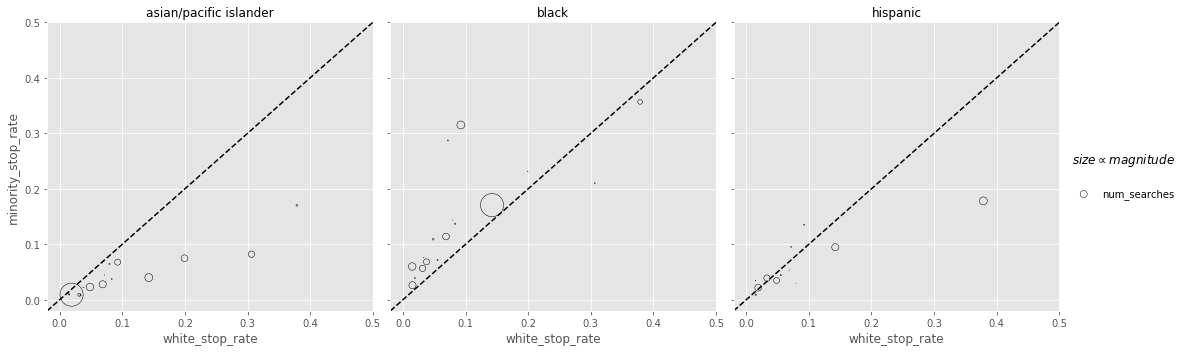

In [11]:
plot_rates_comparison('stop_rate', 
                      stop_rate, 
                      'white', 'minority_group', 'n', 
                      marker_size_scale=200,
                      min_lim = -0.02, 
                      max_lim = 0.5)

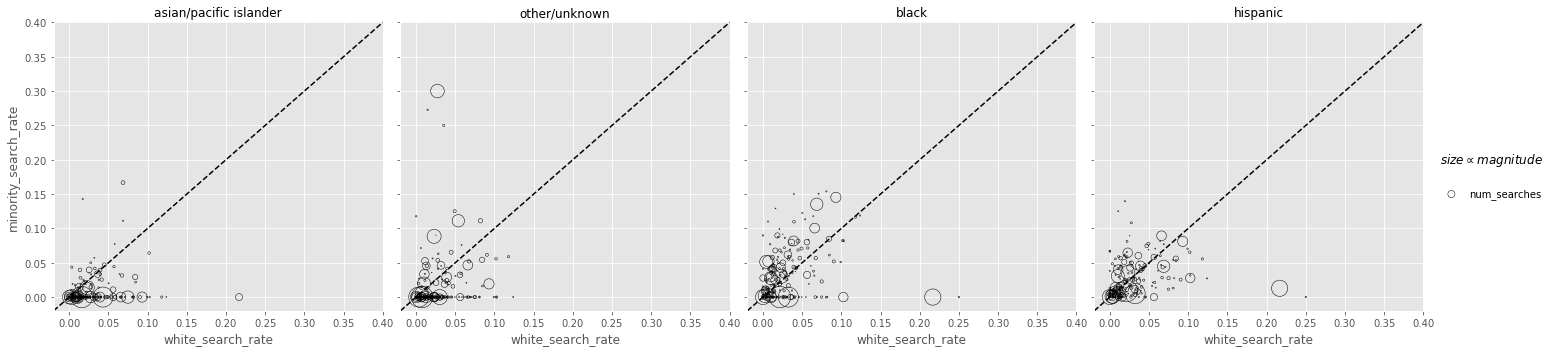

In [18]:
plot_rates_comparison('search_rate', 
                      search_rate, 
                      'white', 'minority_group', 'n', 
                      marker_size_scale = 30,
                      min_lim = -0.02, 
                      max_lim = .4)

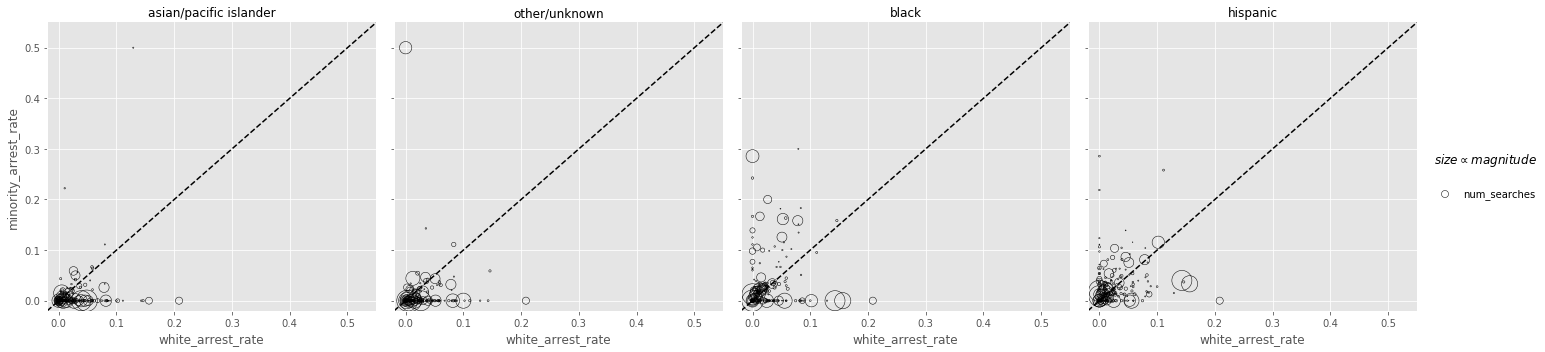

In [19]:
plot_rates_comparison('arrest_rate', 
                      arrest_rate, 
                      'white', 'minority_group', 'n', 
                      marker_size_scale = 30,
                      min_lim = -0.02, 
                      max_lim = 0.55)

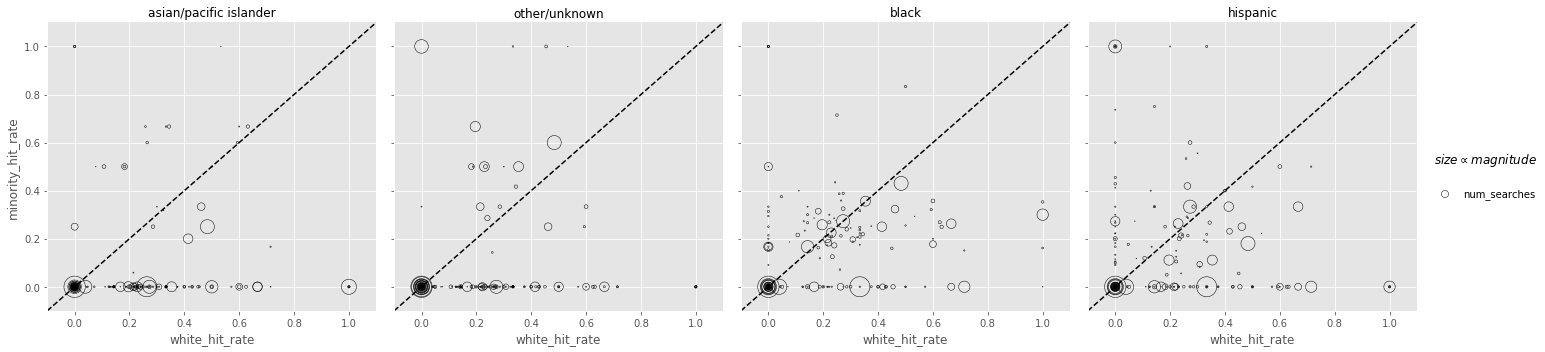

In [21]:
plot_rates_comparison('hit_rate', 
                      hit_rate, 
                      'white', 'minority_group', 'n', 
                      marker_size_scale = 30)